In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import pandas as pd
import warnings
from sklearn.cluster import DBSCAN

warnings.filterwarnings("ignore")


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def LIMA(alpha, Non, Noff):
    sig = np.sqrt(2) * np.sqrt(
        Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
        + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
    )
    if type(sig) is np.ndarray:
        sig[np.where((Non - Noff * alpha) < 0)] = -sig[
            np.where((Non - Noff * alpha) < 0)
        ]
    else:
        if (Non - Noff * alpha) < 0:
            sig = -sig
    sig[np.isnan(sig)] = 0
    return sig


def twoPointAngle(theta1, theta2, phi1, phi2):
    acosangle = np.sin(np.deg2rad(theta1)) * np.sin(np.deg2rad(theta2)) * np.cos(
        np.deg2rad(phi1 - phi2)
    ) + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
    acosangle[acosangle > 1] = 1
    acosangle[acosangle < -1] = -1
    return np.rad2deg(np.arccos(acosangle))


def similarity(x):
    distance = np.zeros([x.shape[0], x.shape[0]])
    for i in range(x.shape[0]):
        # print(i)
        distance[i] = twoPointAngle(x[i, 0], x[:, 0], x[i, 1], x[:, 1])
    return distance


if __name__ == "__main__":
    # headers = [
    #     ">Energy(TeV)",
    #     "gammacut",
    #     "smoothed",
    #     "Ra",
    #     "Dec",
    #     "sigma",
    #     "source number",
    # ]
    Exptdata = np.load(
        "/home2/hky/github/Gamma_Energy/Exptdata/CrabCut_23_05_07_summdcut/cutedData_E_isgamma_RaDec.npz"
    )
    need = np.where((Exptdata["energy"] > 10))
    Exptdata = {key: Exptdata[key][need] for key in Exptdata}
    NSIDE = 2**10
    NPIX = hp.nside2npix(NSIDE)
    reso = 1
    drawdeg = 3
    binsnumber = int(drawdeg * 60 / reso * 2)
    TeVdata = pd.read_table("/home2/hky/github/Gamma_Energy/AllSky_withCR/TeVcat.log")
    Ra_TeVcat = TeVdata["Ra"].to_numpy()
    Dec_TeVcat = TeVdata["Dec"].to_numpy()
    for i in range(len(Ra_TeVcat)):
        Ra_TeVcat_tmp = Ra_TeVcat[i].split()
        Dec_TeVcat_tmp = Dec_TeVcat[i].split()
        Ra_TeVcat[i] = (
            float(Ra_TeVcat_tmp[0]) / 24
            + float(Ra_TeVcat_tmp[1]) / 24 / 60
            + float(Ra_TeVcat_tmp[2]) / 24 / 60 / 60
        ) * 360
        Dec_TeVcat[i] = float(Dec_TeVcat_tmp[0])
        delta_Dec_TeVcat = (
            float(Dec_TeVcat_tmp[1]) / 60 + float(Dec_TeVcat_tmp[2]) / 60 / 60
        )
        Dec_TeVcat[i] += (-1) ** (Dec_TeVcat[i] < 0) * delta_Dec_TeVcat

    Ra_TeVcat = Ra_TeVcat.astype(np.float32)
    Dec_TeVcat = Dec_TeVcat.astype(np.float32)
    TeVname = TeVdata["Name"]
    TeVtype = TeVdata["Type"]
    for para_num in [6]:
        # tablelist = list()
        for gammacut in [0.005]:
            for Energymin in [ 10]:
                # for Energymin in [10, 25, 50, 100]:
                print(Energymin)
                On = np.zeros(NPIX)
                Off = np.zeros(NPIX)
                need = np.where(
                    (Exptdata["energy"] > Energymin)
                    & (Exptdata[f"isgamma_{para_num}"] > gammacut)
                )
                np.add.at(
                    On,
                    hp.ang2pix(
                        NSIDE, Exptdata["Ra"][need], Exptdata["Dec"][need], lonlat=True
                    ),
                    1,
                )
                for i in range(20):
                    np.add.at(
                        Off,
                        hp.ang2pix(
                            NSIDE,
                            Exptdata[f"RaOff_{i}"][need],
                            Exptdata[f"DecOff_{i}"][need],
                            lonlat=True,
                        ),
                        1,
                    )

                # for smoothed in [0.3, 0.5, 0.8, 1, 1.5, 2, 3]:
                for smoothed in [
                    0.3,
                ]:
                    print(smoothed)
                    fwhm = np.deg2rad(smoothed)
                    On_smoothed = hp.smoothing(On, fwhm=fwhm)
                    Off_smoothed = hp.smoothing(Off, fwhm=fwhm)

                    savepath = f"/home2/hky/github/Gamma_Energy/AllSky_withCR/fig/All_sky_new_{para_num}/gammacut_{gammacut:.4f}/Over{Energymin}TeV/smoothed{smoothed:.1f}/"
                    mkdir(savepath)
                    sigma_hp = LIMA(0.05, On_smoothed, Off_smoothed)
                    std = np.std(sigma_hp[(On != 0)])
                    std = np.std(sigma_hp[(On != 0) & (np.abs(sigma_hp) < 5 * std)])
                    sigma_hp /= std
                    pixneed = np.where(sigma_hp > 3.5)[0]
                    print(len(pixneed))

10
0.3
7746


In [1]:
import numpy as np
import uproot
from getS50 import getS50
import matplotlib.pyplot as plt

In [2]:
gammadata = np.load("/home2/hky/github/Gamma_Energy/MCdata/CrabMCData.npz")
gammadata = {key:gammadata[key] for key in gammadata}

In [3]:
gammadata["S50"] = getS50(gammadata["ne"],gammadata["age"])

In [4]:
data = np.load("/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/Datawithe_Galactic_2000_random.npz")
data={key:data[key] for key in data}

In [5]:
gammafile =uproot.open("/home2/chenxu/data/gamma.00339651.root")
gammadata = gammafile["asresult"].arrays(gammafile["asresult"].keys(), library="np")

In [6]:
gammadata["S50"] = getS50(gammadata["ne"],gammadata["age"])
gammaneed = np.where(((gammadata["summd"]<0.4)|(gammadata["summd"]<5.1e-3*gammadata["sumpf"]**1.2))&(gammadata["inout"]==1)&(gammadata["sigma"]<1)&(gammadata["nch"]>=16)&(gammadata["theta"]<60)&(gammadata["S50"]>10**-1.2))


In [53]:
sumpfmin = np.array([30,100, 200, 400, 800, 1000, 2000])
for i, sumpfmin_i in enumerate(sumpfmin):
    gammaneed1 = np.where(((gammadata["summd"]<0.4)|(gammadata["summd"]<5.1e-3*gammadata["sumpf"]**1.2))&(gammadata["inout"]==1)&(gammadata["sigma"]<1)&(gammadata["nch"]>=16)&(gammadata["theta"]<60)&(gammadata["S50"]>10**-1.2)&(gammadata["sumpf"]>sumpfmin_i))
    gammaneed2 = np.where((gammadata["inout"]==1)&(gammadata["sigma"]<1)&(gammadata["nch"]>=16)&(gammadata["theta"]<60)&(gammadata["S50"]>10**-1.2)&(gammadata["sumpf"]>sumpfmin_i))
    print(len(gammaneed1[0])/len(gammaneed2[0]))

0.9651061673267517
0.9668981447475417
0.971961024085301
0.972676290599451
0.9709905945718267
0.9703764532760887
0.9689348951830903


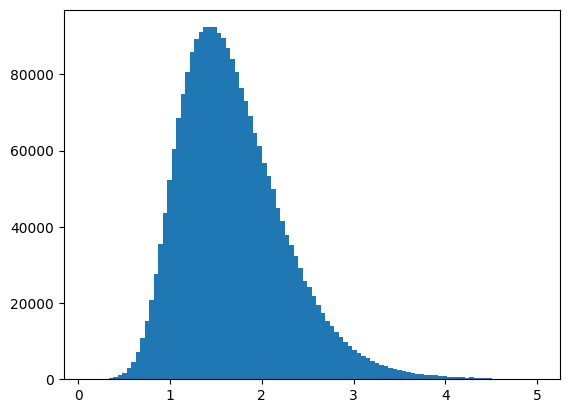

49.15032350928771 20.633623326226356


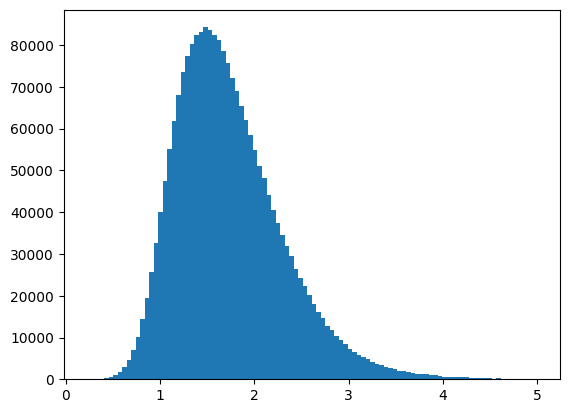

54.41510716934926 25.85234182149759


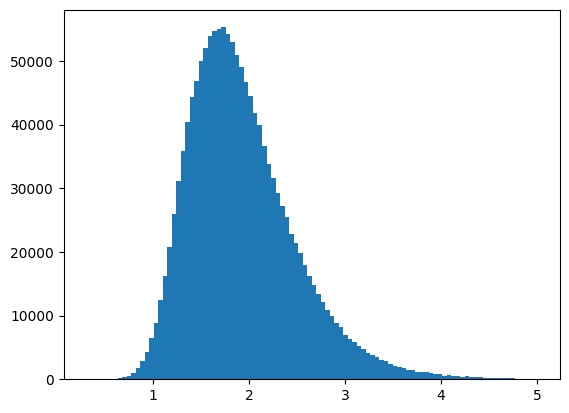

84.68660974125191 88.30582580624043


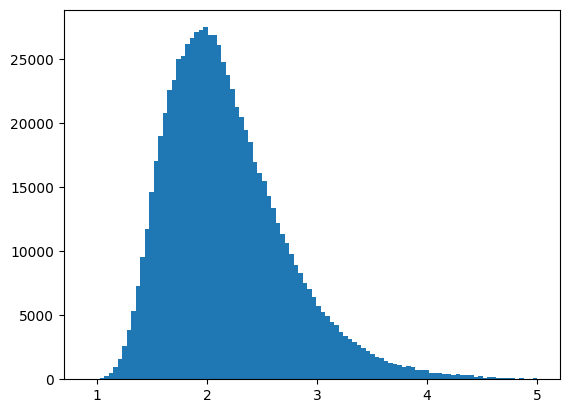

151.97873948143348 84.5539036187893


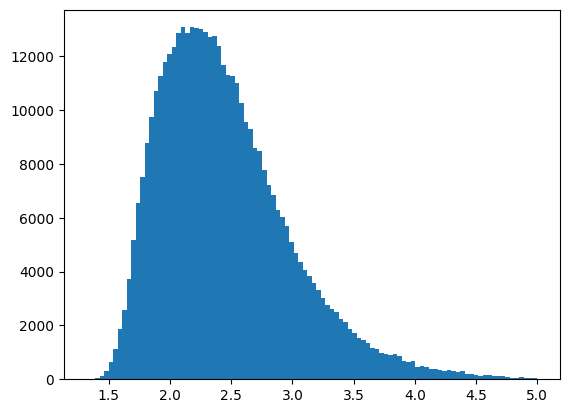

283.7377739837119 171.95531262869784


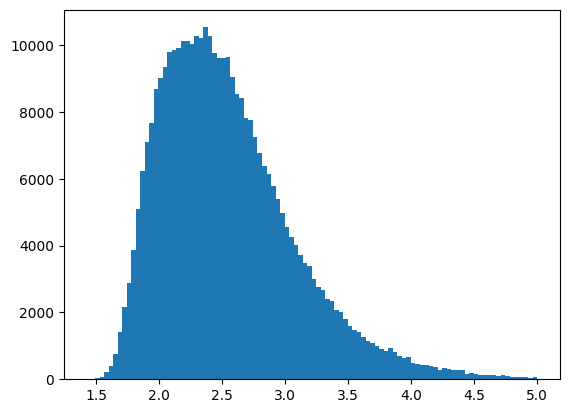

350.1404506339544 205.99469286562066


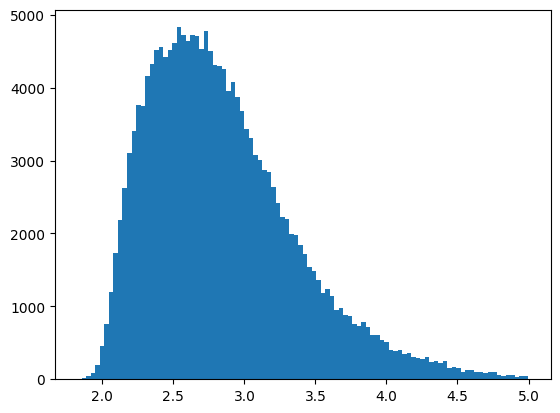

698.5221086103062 414.7803251955009


In [43]:
sumpfmin = np.array([30,100, 200, 400, 800, 1000, 2000])
for i, sumpfmin_i in enumerate(sumpfmin):
    gammaneed1 = np.where(((gammadata["summd"]<0.4)|(gammadata["summd"]<5.1e-3*gammadata["sumpf"]**1.2))&(gammadata["inout"]==1)&(gammadata["sigma"]<1)&(gammadata["nch"]>=16)&(gammadata["theta"]<60)&(gammadata["S50"]>10**-1.2)&(gammadata["sumpf"]>sumpfmin_i))
    plt.hist(np.log10(gammadata["prie"][gammaneed1]/1000),bins=100)
    plt.show()
    hist,edge = np.histogram(np.log10(gammadata["prie"][gammaneed1]/1000))
    edge_center = (edge[1:]+edge[:-1])/2
    print(10**np.mean(np.log10(gammadata["prie"][gammaneed1]/1000)),10**(edge_center[np.argmax(hist)]))

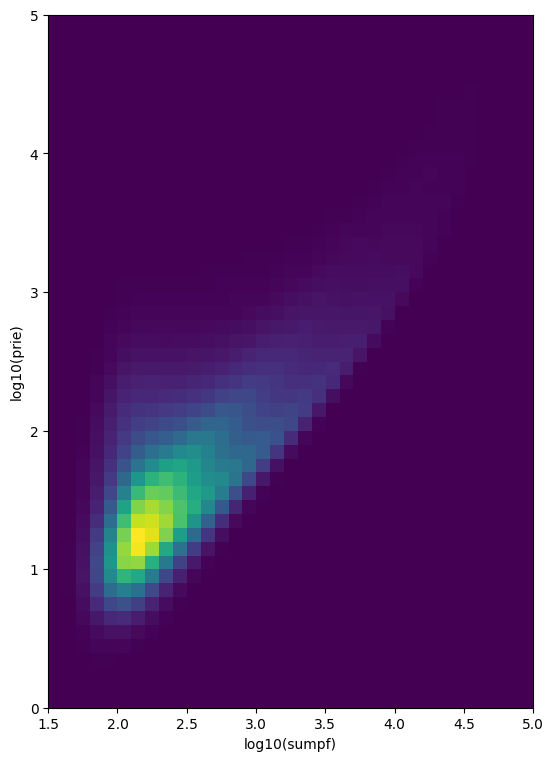

In [51]:
gammaneed1 = np.where(((gammadata["summd"]<0.4)|(gammadata["summd"]<5.1e-3*gammadata["sumpf"]**1.2))&(gammadata["inout"]==1)&(gammadata["sigma"]<1)&(gammadata["nch"]>=16)&(gammadata["theta"]<60)&(gammadata["S50"]>10**-1.2))
Ebins=np.linspace(0,5,51)
sumpfbins=np.linspace(1.5,5,36)
H, xedges, yedges = np.histogram2d(np.log10(gammadata["sumpf"][gammaneed1]), np.log10(gammadata["prie"][gammaneed1]/1000), bins=(sumpfbins, Ebins))
H = H.T
fig = plt.figure(figsize=(9, 9))
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel("log10(sumpf)") 
plt.ylabel("log10(prie)")
plt.show()

In [8]:
data_need = dict()
paraneed = [
    "theta",
    "sumpf",
    "summd",
    "mr1",
    "cx",
    "cy",
    "prie"
]
data["prie"]=np.zeros_like(data["theta"])
for para in paraneed:
    data_need[para] = np.concatenate(
        [
            data[para][np.abs(data["b"]) > 6],gammadata[para][gammaneed]
        ]
    )


In [9]:
gammadata[para][gammaneed].shape

(2460460,)

In [10]:
data[para][np.abs(data["b"]) > 6].shape

(1757804,)

In [11]:
data_need["isgamma"] = np.ones_like(data_need["theta"])
data_need["isgamma"][:len(data[para][np.abs(data["b"]) > 6])]=0

In [12]:
from sklearn.model_selection import train_test_split
train_index, test_index = train_test_split(
    range(len(data_need["isgamma"])), test_size=0.4, random_state=42
)
trainData = {key: data_need[key][train_index] for key in data_need.keys()}
testData = {key: data_need[key][test_index] for key in data_need.keys()}
np.savez(
    "/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/Datawithe_Galactic_2000_withMC_train_random.npz",
    **trainData
)
np.savez(
    "/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/Datawithe_Galactic_2000_withMC_test_random.npz",
    **testData
)


In [13]:
for i in gammadata:
    print(i)

runno
evno
mode
mjd
nch
inout
oldtrig
theta
phi
evenodd
sigma
cx
cy
sumpf
sumpd
mr1
mr2
summd
summdold
summd8
nchmd
ne
age
ndf
chi2
fptcl_r
dptcl_r
fn_r
dn_r
JPne
JPne_err
JPage_err
JPage
JPchi2
JPdof
nch_cx
sigma_cx
ne_cx
age_cx
cx_cx
cy_cx
theta_cx
phi_cx
prie_num
prik
priid
pritheta
priphi
prie
prine
pricx
pricy


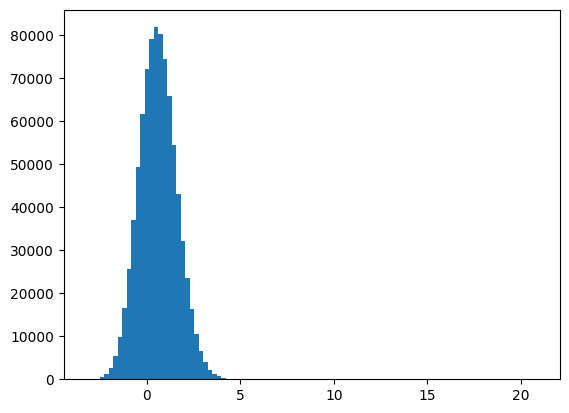

In [2]:
plt.hist(sigma_hp[(On != 0)],bins=100)
plt.show()

In [7]:
sigma_hp = LIMA(0.05, On_smoothed, Off_smoothed)

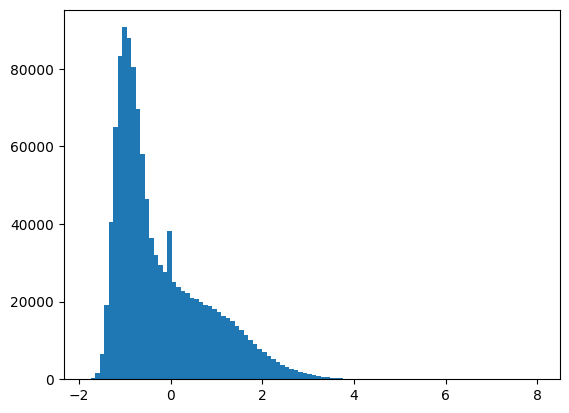

In [19]:
std = np.std(sigma_hp[(On != 0)|(Off!=0)])
plt.hist(sigma_hp[(On != 0)|(Off!=0)]/std,bins=100)
plt.show()